# Mitosis length detection with CNN

## Imports

In [11]:
import os
import numpy as np
import pandas as pd
import keras
import itertools
import time 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import tifffile as tiff
import matplotlib
import tensorflow as tf

from IPython.display import display
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import save_img
from keras.callbacks import TensorBoard
from numpy import asarray

from sklearn.metrics import confusion_matrix

from time import strftime

import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from PIL import Image

import cv2

from numpy import genfromtxt

from sklearn.preprocessing import MinMaxScaler

## Constants

In [3]:
Z_STACKS = 85

### Import embryo image
Note: Image is 1024x1024

In [44]:
embryo = tiff.imread('/Users/Uzivatel/Documents/Confocal/max_projections/Position 1_Settings 1_max.tif')

In [45]:
len(embryo) # Number of z-stacks, or time frames

85

In [46]:
embryo[0]

array([[[ 109,  111,  108, ...,  109,  107,  110],
        [ 110,  114,  111, ...,  111,  107,  113],
        [ 109,  110,  107, ...,  108,  110,  109],
        ...,
        [ 110,  109,  110, ...,  114,  107,  109],
        [ 109,  110,  114, ...,  113,  109,  107],
        [ 108,  112,  111, ...,  110,  109,  108]],

       [[3669, 3603, 3705, ..., 4074, 3934, 4080],
        [3688, 3652, 3644, ..., 3934, 3955, 4086],
        [3640, 3635, 3697, ..., 4051, 3967, 4001],
        ...,
        [7470, 7488, 7555, ..., 7200, 7121, 7024],
        [7467, 7478, 7475, ..., 7051, 7128, 7191],
        [7502, 7554, 7359, ..., 7122, 7121, 6990]]], dtype=uint16)

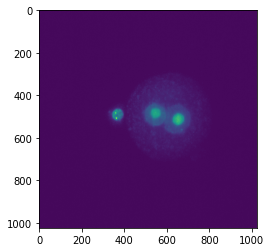

In [47]:
# First z-stack of embryo. Resolution is 1024x1024
plt.imshow(embryo[0 ,0,:])
plt.show()

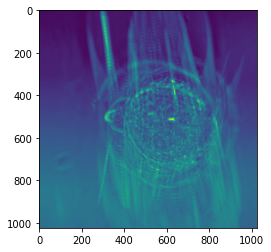

In [48]:
# First brightfield z-stack
plt.imshow(embryo[0 ,1,:])
plt.show()

### Image preprocessing

Function to simplify image opening and preparing data for CNN
1) Open embryo and remove brightfield 
2) Find the brightest image in size 256x256

In [5]:
def crop_image(file):
    # Remove brightfield and create list of embryos z-stacks    
    file = file[:, 0, :]    
    embryos_list = []
    for i in range(Z_STACKS):
        embryos_list.append(file[i])
        
    # Iterate trough an image and save all 250x250 images to a list
    cropped_images = []
    for embryo in range(len(embryos_list)):
        # Initialize coordinates in the right corner (0, 0 - 256, 256)  
        x1 = 0
        x2 = 256
        y1 = 0
        y2 = 256

        cropped_slices = [] # At the end of iteration it will contain all images
        for i in range (768):
            for j in range (768):
                cropped_slice = embryos_list[embryo][x1: x2, y1: y2]
                cropped_slices.append(cropped_slice)
                x1 += 1
                x2 += 1        
            y1+=1
            y2+=1    
            x1=0
            x2=256   
            
        # Find the brightest images
        sum_values_list = [image.sum() for image in cropped_slices]
        max_image_position = sum_values_list.index(max(sum_values_list))
        cropped_image = cropped_slices[max_image_position]
        cropped_images.append(cropped_image)
    return cropped_images

## Save images to a variable

In [50]:
start_time = time.time()
data = crop_image(embryo)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

3276.0016689300537


It took 60 minutes to run the function, just for 1 embryo

### Images visualization

In [51]:
data[10]

array([[109, 108, 116, ..., 107, 109, 109],
       [111, 113, 109, ..., 113, 114, 111],
       [109, 114, 111, ..., 110, 108, 111],
       ...,
       [118, 113, 118, ..., 114, 110, 107],
       [124, 116, 113, ..., 112, 114, 121],
       [121, 114, 117, ..., 114, 117, 113]], dtype=uint16)

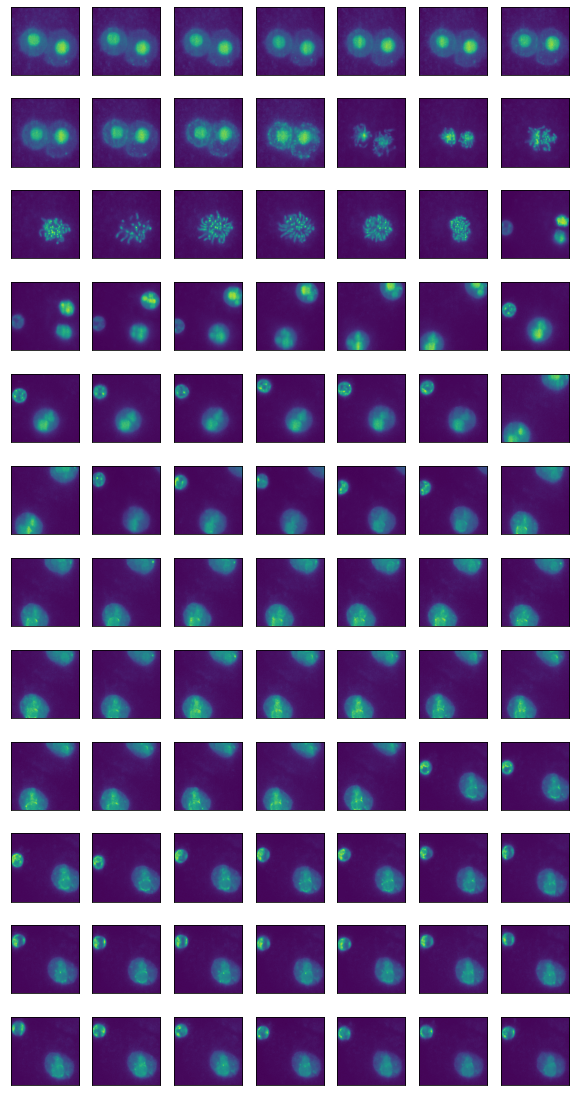

In [52]:
fig = plt.figure(figsize=(10, 20))
columns = 7
rows = 12
for i in range(1, columns*rows +1):
    img = data[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

## Mitotic images from the first embryo:

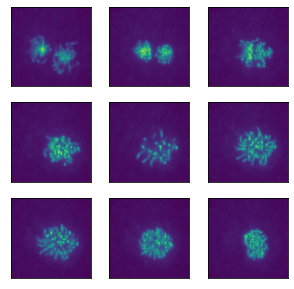

In [235]:
fig = plt.figure(figsize=(5, 5))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = rescaled_data[i+11]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [120]:
print(f'Minimum value of the first image is {data[0].min()} and the maximum is {data[0].max()}')

Minimum value of the first image is 108 and the maximum is 347


## Rescale images to 0 - 256

In [107]:
rescaled_data = []
# return minus values that I don't want, so I will use ReLu function to delete minus values
def relu(x):
    return np.maximum(0, x)

for i in range (Z_STACKS):    
    rescaled_image = data[i].astype('int64') - data[i].max() + 256
    rescaled_image = relu(rescaled_image)
    rescaled_data.append(rescaled_image)

In [97]:
data[10]

array([[109, 108, 116, ..., 107, 109, 109],
       [111, 113, 109, ..., 113, 114, 111],
       [109, 114, 111, ..., 110, 108, 111],
       ...,
       [118, 113, 118, ..., 114, 110, 107],
       [124, 116, 113, ..., 112, 114, 121],
       [121, 114, 117, ..., 114, 117, 113]], dtype=uint16)

In [108]:
rescaled_data_min_max = []
# return rescaled data with linearisation
for i in range (Z_STACKS):
    a = 255/(data[i].max()-data[i].min())
    c = -a * data[i].min()
    y = np.around(a * data[i] + c)
    rescaled_data_min_max.append(y)

### Show rescaled pictures

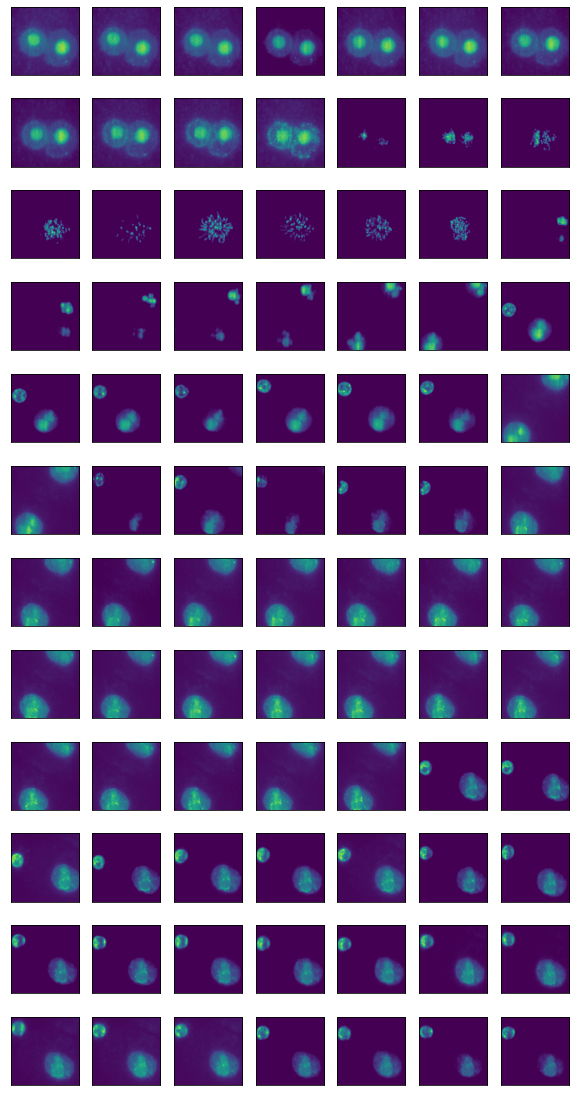

In [106]:
# Rescaled with Relu
fig = plt.figure(figsize=(10, 20))
columns = 7
rows = 12
for i in range(1, columns*rows +1):
    img = rescaled_data[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

During mitosis there is lost of infomration

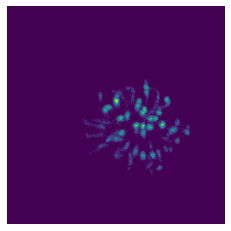

In [112]:
plt.imshow(rescaled_data[18])
plt.axis('off')
# plt.savefig('my_data.jpg', bbox_inches='tight', pad_inches = 0 ) # In the case I would like to save the picture
plt.show()

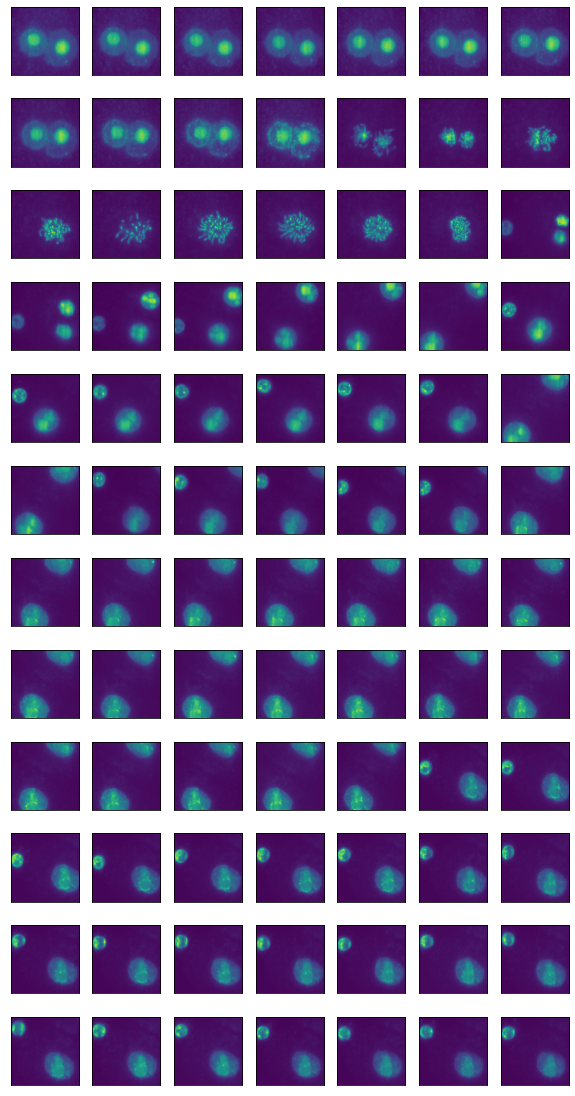

In [113]:
# Images from linearization rescale
fig = plt.figure(figsize=(10, 20))
columns = 7
rows = 12
for i in range(1, columns*rows +1):
    img = rescaled_data_min_max[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

## Create folder and save images as CSV files

First image as a np array

In [115]:
embryo_number = 2
os.mkdir(f'embryo_{embryo_number}_csvs_rescaled') # This code is only for 1 embryo, in the case of all embryos - f'embryo_{}_csv'
for i in range(Z_STACKS):
    pd_cropped_embryos = pd.DataFrame(rescaled_data_min_max[i])
    pd_cropped_embryos.to_csv(f'embryo_{embryo_number}_csvs_rescaled/embryo_{embryo_number}_{i}_rescaled.csv')

### Read images from CSV

In [3]:
image_data = []
for i in range(85):
    img = pd.read_csv(f'embryo_2_csvs/embryo_2_{i}.csv')
    img = img.iloc[: , 1:]
    image_data.append(img)

In [116]:
# Save as jpg

# plt.imshow(image_data[18])
# plt.axis('off')
# # plt.savefig('my_data.jpg', bbox_inches='tight', pad_inches = 0 ) # In the case I would like to save the picture
# plt.show()

### Save images as JPEG for CNN


In [ ]:
# plt.imshow(image_data[18])
# plt.axis('off')
# # plt.savefig('my_data.jpg', bbox_inches='tight', pad_inches = 0 ) # In the case I would like to save the picture
# plt.show()

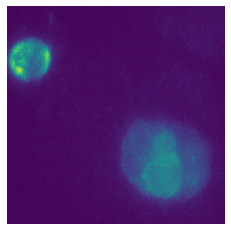

In [117]:
embryo_number = 2
os.mkdir(f'embryo_{embryo_number}_csvs_jpg') # This code is only for 1 embryo, in the case of all embryos - f'embryo_{}_csv'
for i in range(Z_STACKS):
    plt.imshow(image_data[i])
    plt.axis('off')
    plt.savefig(f'embryo_{embryo_number}_csvs_jpg/embryo_{embryo_number}_{i}.jpg', bbox_inches='tight', pad_inches = 0 ) # In the case I would like to save the picture
    

## Automatically open embryo, rescale and write as JPG 
Functions are tide together

In [2]:
def crop_image(file):
    # Remove brightfield and create list of embryos z-stacks    
    file = file[:, 0, :]    
    embryos_list = []
    for i in range(Z_STACKS):
        embryos_list.append(file[i])
        
    # Iterate trough an image and save all 250x250 images to a list
    cropped_images = []
    for embryo in range(len(embryos_list)):
        # Initialize coordinates in the right corner (0, 0 - 256, 256)  
        x1 = 0
        x2 = 256
        y1 = 0
        y2 = 256

        cropped_slices = [] # At the end of iteration it will contain all images
        for i in range (768):
            for j in range (768):
                cropped_slice = embryos_list[embryo][x1: x2, y1: y2]
                cropped_slices.append(cropped_slice)
                x1 += 1
                x2 += 1        
            y1+=1
            y2+=1    
            x1=0
            x2=256   
            
        # Find the brightest images
        sum_values_list = [image.sum() for image in cropped_slices]
        max_image_position = sum_values_list.index(max(sum_values_list))
        cropped_image = cropped_slices[max_image_position]
        cropped_images.append(cropped_image)
    return cropped_images

In [3]:
def rescale_data(data):
    rescaled_data = []
    for i in range (Z_STACKS):
        a = 255/(data[i].max()-data[i].min())
        c = -a * data[i].min()
        y = np.around(a * data[i] + c)
        rescaled_data.append(y)
    return rescaled_data

In [8]:
# Changed plt.savefig to cv2.imwrite
def save_as_jpg(image_data):
    os.mkdir(f'embryo_{current_embryo}_csvs_jpg')
    for i in range(Z_STACKS):
        cv2.imwrite(f'embryo_{current_embryo}_csvs_jpg/embryo_{current_embryo}_{i}.jpg', image_data[i])

In [6]:
embryos = [4] # Add embryo position to a list 
Z_STACKS = 85

for i in embryos:
    current_embryo = i
    embryo = tiff.imread(f'/Users/Uzivatel/Documents/Confocal/max_projections/Position {i}_Settings 1_max.tif')

    start_time = time.time()
    data = crop_image(embryo)
    rescaled_data = rescale_data(data)
    save_as_jpg(rescaled_data)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f'It took {execution_time/60} minutes')

It took 52.6324937582016 minutes


### Mitosis detection

In [9]:
data_dir = 'embryo_2_csvs_jpg'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [18]:
directory = 'embryos/0' # File where are all embryo files
array_containter = []
images = []
for filename in os.listdir(directory):
    file = os.path.join(directory, filename)
    image = Image.open(file)
    images.append(image)

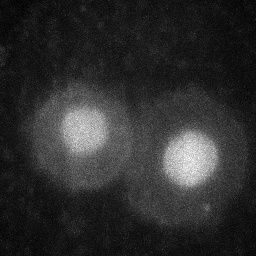

In [20]:
images[0]